In [ ]:
!unzip '/content/Pressure Ulcer.v1i.folder.zip'

Archive:  /content/Pressure Ulcer.v1i.folder.zip
  inflating: Pressure Ulcer Classification.v1i.folder/README.dataset.txt  
  inflating: Pressure Ulcer Classification.v1i.folder/README.roboflow.txt  
   creating: Pressure Ulcer Classification.v1i.folder/test/
   creating: Pressure Ulcer Classification.v1i.folder/test/1/
  inflating: Pressure Ulcer Classification.v1i.folder/test/1/stage_1_25991_jpg.rf.68a8dc1d990235d184ef594d006f383d.jpg  
  inflating: Pressure Ulcer Classification.v1i.folder/test/1/stage_1_27512_jpg.rf.06bab3982e67f09950fab5b5e8a60474.jpg  
  inflating: Pressure Ulcer Classification.v1i.folder/test/1/stage_1_35803_jpg.rf.85009b96c736d935bc739a841a6f2819.jpg  
  inflating: Pressure Ulcer Classification.v1i.folder/test/1/stage_1_38303_jpg.rf.faab0c62e733cff0b69e59249665b3ee.jpg  
  inflating: Pressure Ulcer Classification.v1i.folder/test/1/stage_1_38366_jpg.rf.5a1bee384ed89e8a97e031ce2527c07e.jpg  
  inflating: Pressure Ulcer Classification.v1i.folder/test/1/stage_1_4279

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    '/content/Pressure Ulcer Classification.v1i.folder/train',  # Path to training data directory
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/Pressure Ulcer Classification.v1i.folder/valid',  # Path to testing data directory
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

Found 795 images belonging to 4 classes.
Found 175 images belonging to 4 classes.


In [ ]:
path = '/content/Pressure Ulcer Classification.v1i.folder/train'

In [ ]:
import os
class_names = sorted(os.listdir(path))
num_classes = len(class_names)

img_size = (192, 192, 3)

print('classes: ', class_names)

classes:  ['1', '2', '3', '4']


In [ ]:
import os
import numpy as np
import cv2

# Define the base path to your dataset
path = '/content/Pressure Ulcer Classification.v1i.folder/train/'

# Define the class names based on your folder structure
class_names = ['1', '2', '3', '4']
num_classes = len(class_names)

# Check if the path exists
if not os.path.exists(path):
    print(f"Error: The directory '{path}' does not exist.")
else:
    labels = []
    images = []

    print('Images:\n')
    for cl in class_names:
        class_path = os.path.join(path, cl)
        if not os.path.exists(class_path):
            print(f"Warning: The class directory '{class_path}' does not exist. Skipping...")
            continue

        print(cl, end=' -> ')
        for img in os.listdir(class_path):
            label = np.zeros(num_classes)
            label[class_names.index(cl)] = 1
            labels.append(label)

            image_path = os.path.join(class_path, img)
            image = np.asarray(cv2.resize(cv2.imread(image_path, cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1])  # Convert BGR to RGB
            images.append(image)
        print('done')

    labels = np.asarray(labels)
    images = np.asarray(images)

print(f'\n\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')


Images:

1 -> done
2 -> done
3 -> done
4 -> done


labels shape: (795, 4)
images shape: (795, 192, 192, 3)


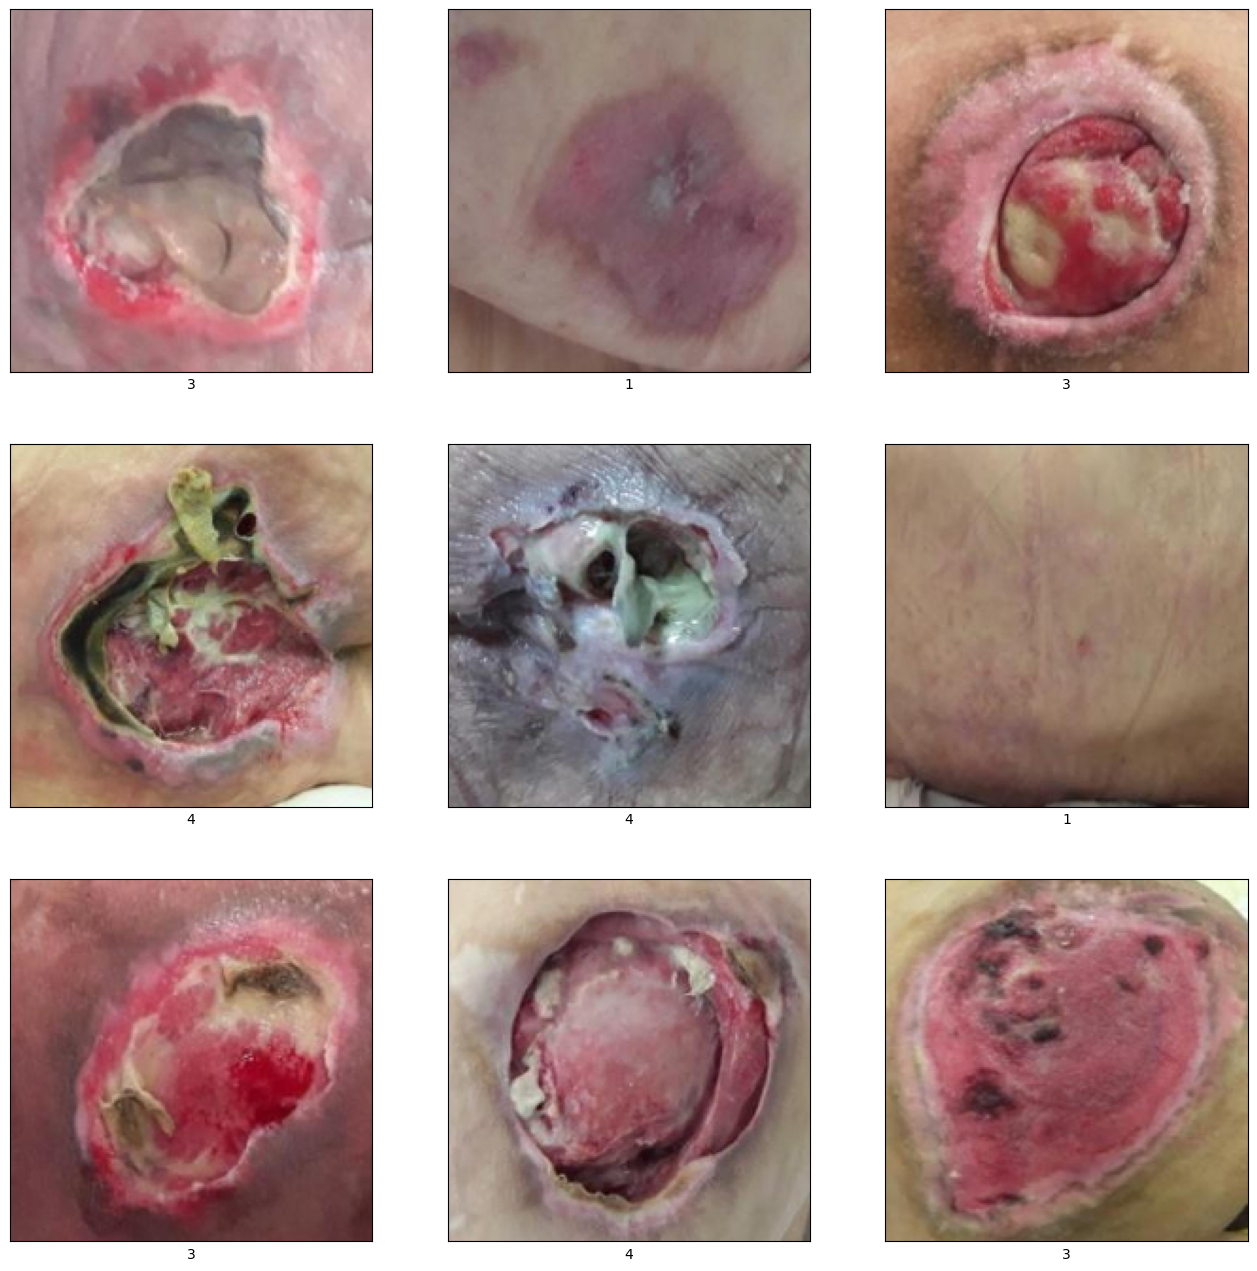

In [ ]:
from random import randint

fig, axs = plt.subplots(3, 3, figsize=(16, 16))#Original was 10,6

for x in range(3):
    for y in range(3):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])


        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])


plt.show()

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (675, 192, 192, 3)
train labels shape: (675, 4)

validation images shape: (120, 192, 192, 3)
validation labels shape: (120, 4)



In [ ]:
import tensorflow as tf

cnn_model = tf.keras.Sequential()

# Inputs and rescaling
cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=(img_size)))

# Convolutional block 1
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 2
cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 3
cnn_model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())

# Dense block
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 192, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      18,874,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,245,828 (73.42 MB)

 Trainable params: 19,245,828 (73.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# creating ModelCheckpoint callback with .keras extension
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}.keras')


In [ ]:
history = cnn_model.fit(images, labels, epochs=5, validation_data=(X_val, y_val)) #, callbacks=[checkpoint_callback]

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - accuracy: 0.2883 - loss: 2.8078 - val_accuracy: 0.4417 - val_loss: 1.3601
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.3746 - loss: 1.3162 - val_accuracy: 0.4500 - val_loss: 1.1875
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step - accuracy: 0.4295 - loss: 1.1634 - val_accuracy: 0.4917 - val_loss: 0.9761
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 209s 8s/step - accuracy: 0.5563 - loss: 0.9626 - val_accuracy: 0.5667 - val_loss: 0.9164
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - accuracy: 0.5636 - loss: 0.9567 - val_accuracy: 0.6333 - val_loss: 0.8783


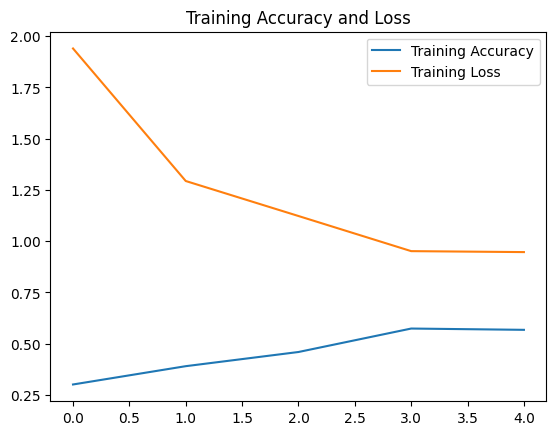

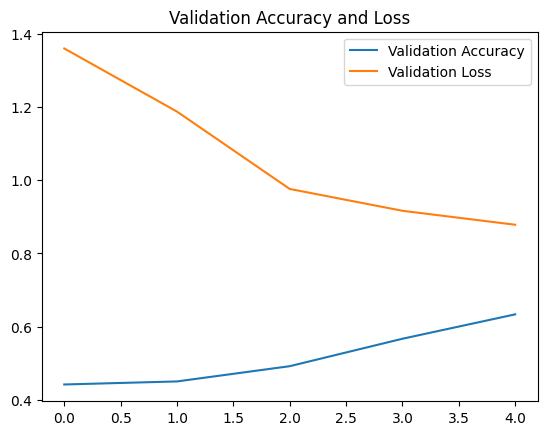

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

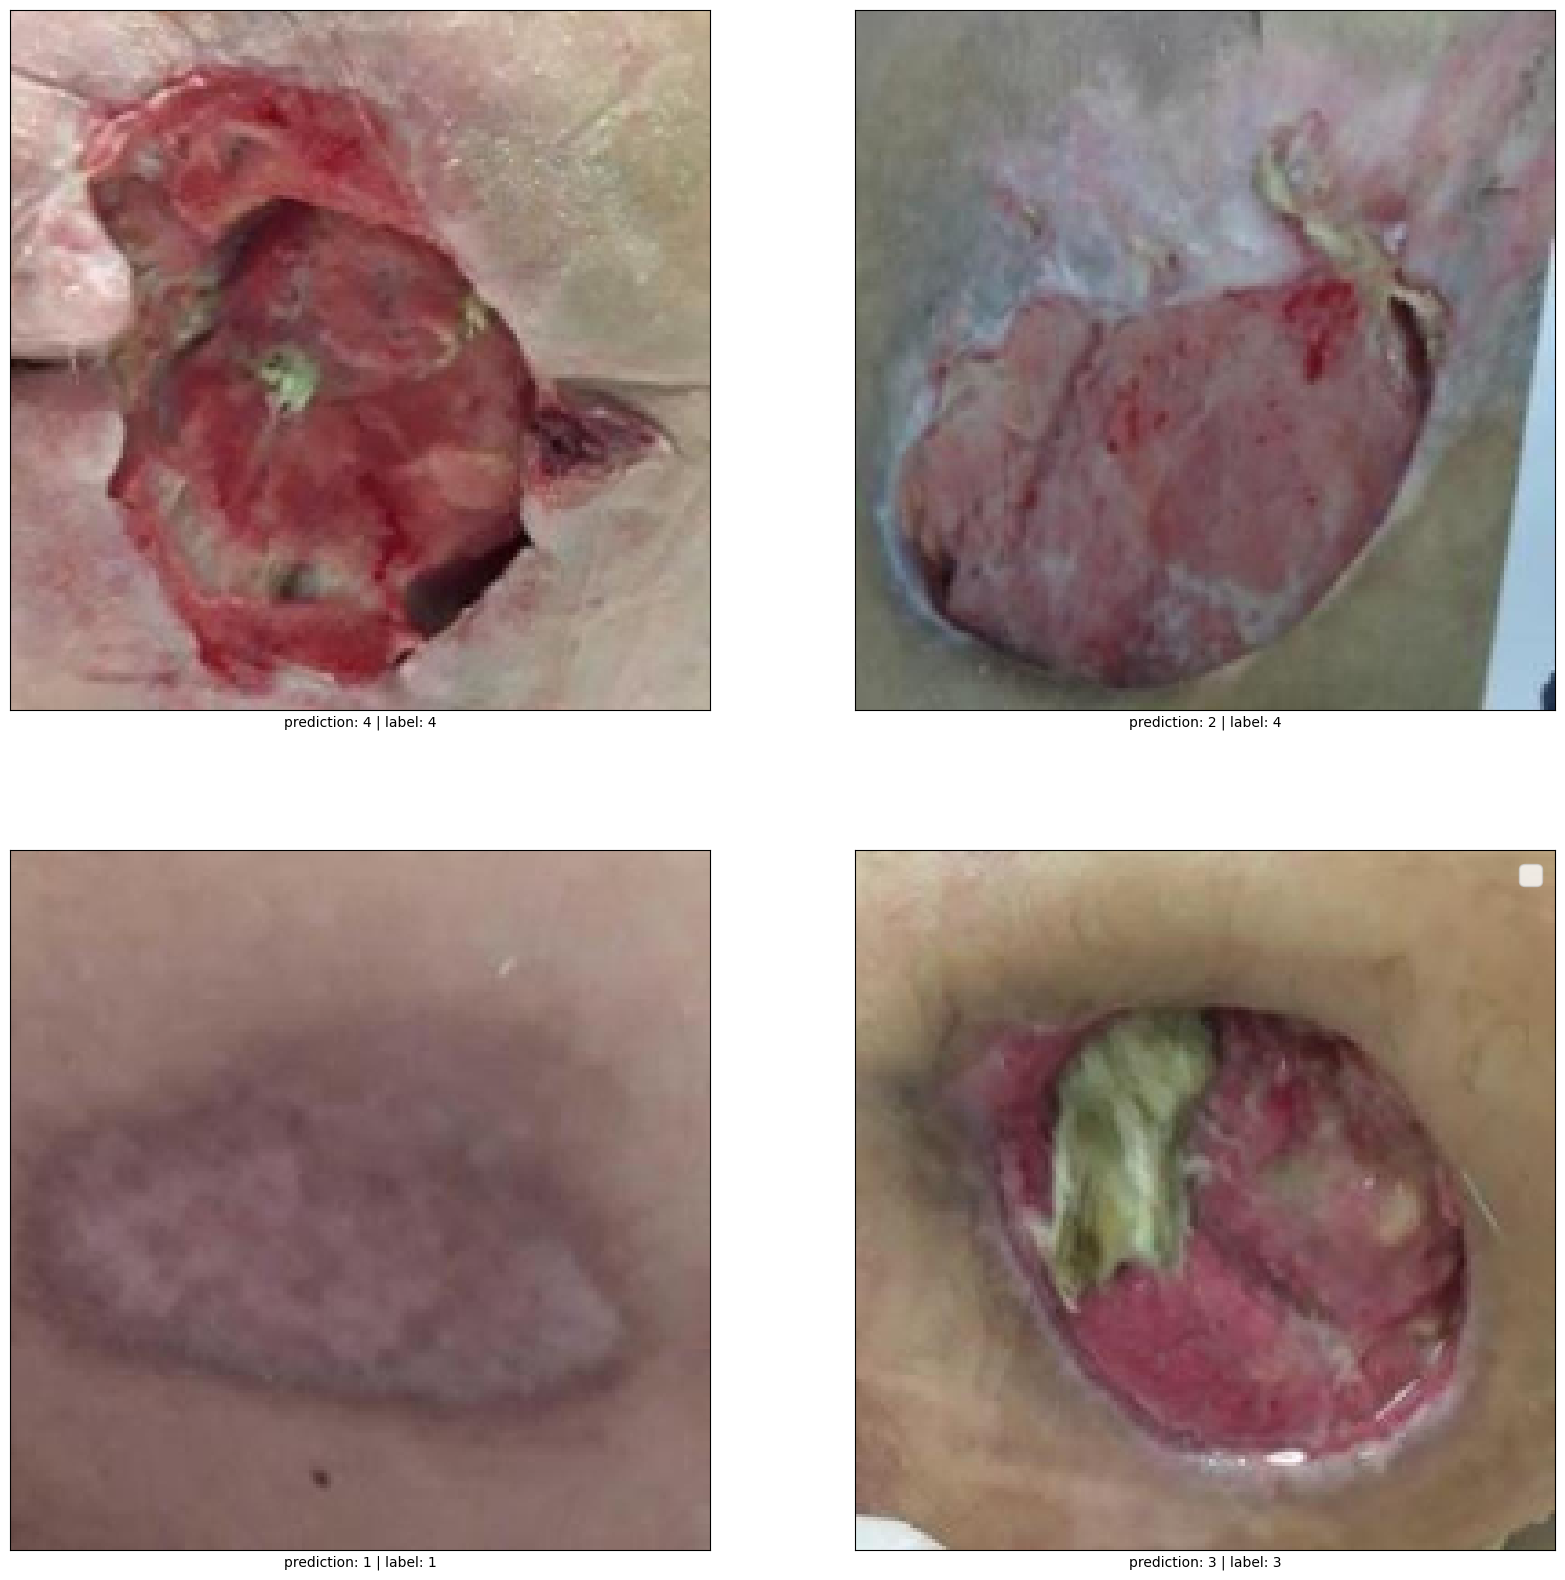

In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(20, 20))#Original was 7,4 (28 is higher than 25) and figsize 15,15
plt.legend(fontsize="20")#I can't read any of them

i = 0
for x in range(2): #Original was 7 so resulted in error 7X4 = 28
    for y in range(2):
        prediction = cnn_model.predict(X_val[i][None, ...], verbose=0)[0],


        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()


In [ ]:

cnn_model.save("skin_disease.h5")